In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

from datetime import datetime

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
prod_data = pd.read_csv('data/product_data.csv', parse_dates=['Date'])
prod_data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


Some values in the `Order_Demand` column are bounded by parentheses, which makes an extra speed bump in parsing these in as integers.

In [3]:
prod_data['Order_Demand'] = prod_data['Order_Demand'].str.strip('()')
prod_data['Order_Demand'] = prod_data['Order_Demand'].astype(int)

First, some data cleaning.  Orders with no date attached are worthless to us, so they should be removed.  Furthermore, we should be cautious with forecasting for products that have a large number of un-dated orders, since we know for certain our models are missing data in these cases.

Data for the year 2011 is spotty, it starts being consistent in 2012.

In [4]:
prod_data = prod_data.query('not Date.isnull()')
prod_data = prod_data.query('Date.dt.year >= 2012')

# Feature Engineering

Now that some preliminary cleaning is taken care of, let's group order demand by month and product.  This will allow us to more easily explore the data and carry out forecasting.

In [5]:
prod_data['Month'] = prod_data['Date'].apply(
    lambda dt: dt.replace(day=1))

In [6]:
agg_cols = ['Product_Code', 'Month', 'Order_Demand']
agg_data = prod_data[agg_cols].groupby(['Product_Code', 'Month']).sum()

In [7]:
# we actually need to operate on month, this moves it back into a column
agg_data.reset_index(level=['Product_Code', 'Month'], inplace=True)

agg_data['Month_of_Year'] = agg_data.apply(
    lambda r: r['Month'].month,
    axis=1
)

# Data Exploration

It's important that we choose our product to forecast wisely.  Looking at the products in highest demand makes sense, for two reasons.  First, higher volume products will have more data for us to work with, and likely be less prone to high volatility.  Second, from a business perspective optimizing the logistics of the most ordered products is likely to yield the most benefit.

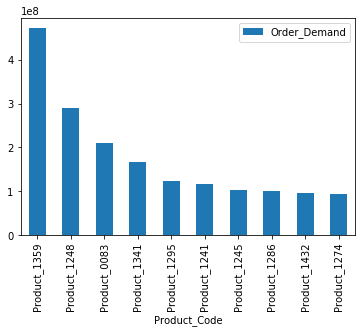

In [8]:
total_counts = agg_data[['Product_Code', 'Order_Demand']].groupby('Product_Code').sum()
total_counts.reset_index(level=['Product_Code'], inplace=True)
total_counts.nlargest(10, 'Order_Demand').plot.bar(x='Product_Code', y='Order_Demand')

Now that we've got the ten most popular products, let's take a look at demand over time.  Ideally we'll find some product with distinct patterns we'd like to extrapolate.

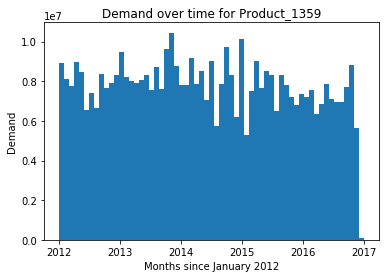

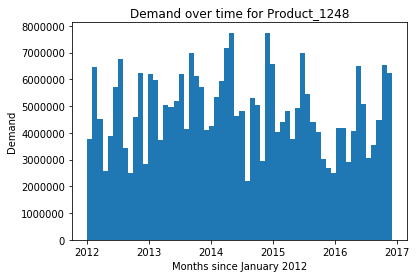

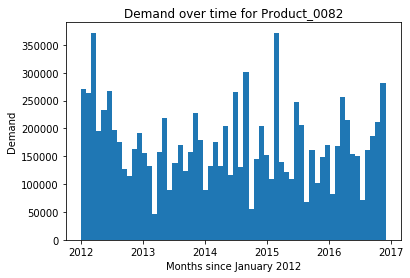

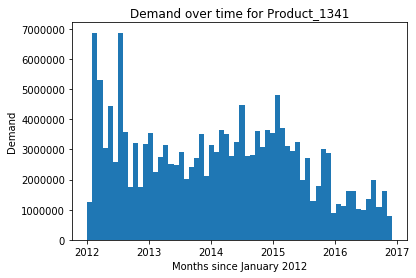

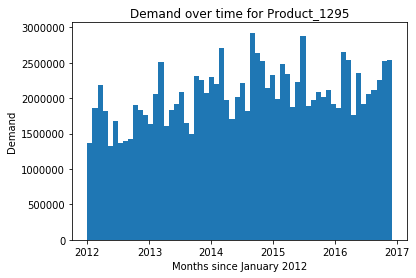

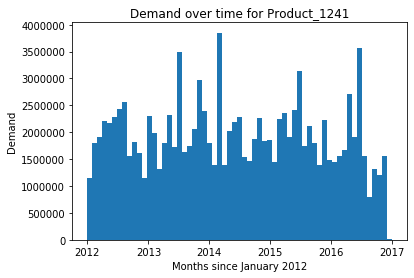

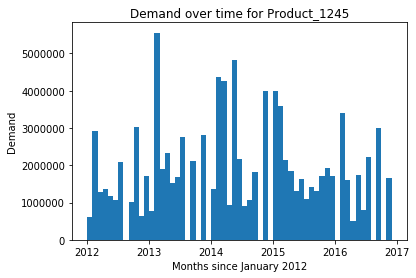

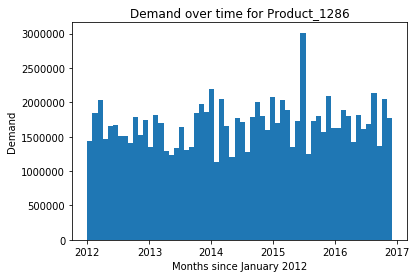

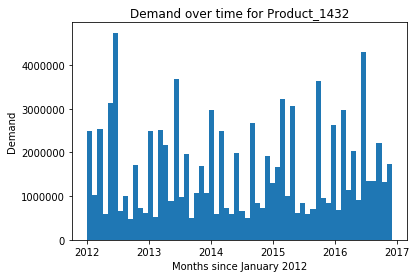

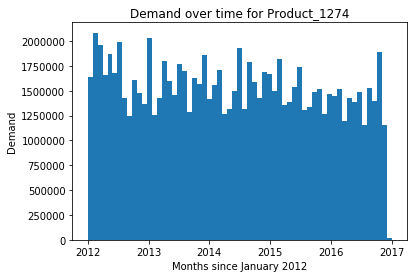

In [9]:
largest = ["1359", "1248", "0082", "1341", "1295", "1241", "1245", "1286", "1432", "1274"]

def plot_product(prod_name):
    prod = agg_data.query(f'Product_Code == "{prod_name}"')
    prod = prod.sort_values('Month')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.hist(prod['Month'], bins=len(prod['Month']), weights=prod['Order_Demand'])
    ax.set_title(f'Demand over time for {prod_name}')
    ax.set_xlabel('Months since January 2012')
    ax.set_ylabel('Demand')
    plt.show()

for p in largest:
    plot_product(f'Product_{p}')

It looks like 1295 is on a distinct upward trend, that may be a good candidate for forecasting.  Product 1432 has very high volatility, but it's hard to tell from this graph if this is seasonal.  To get an idea of the seasonality of these products, we can also take a look at a histogram of month of the year.

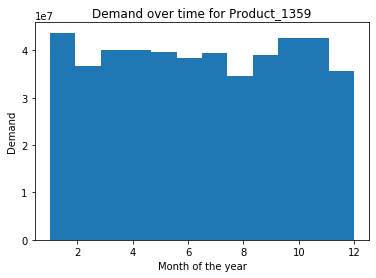

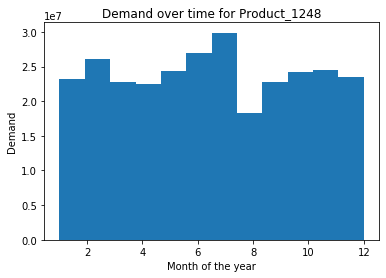

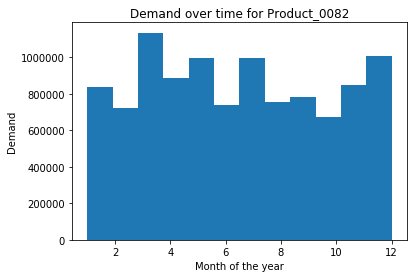

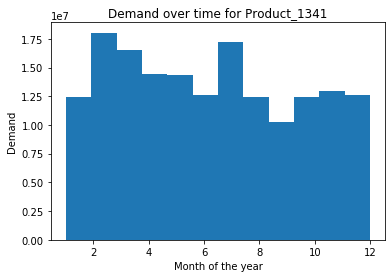

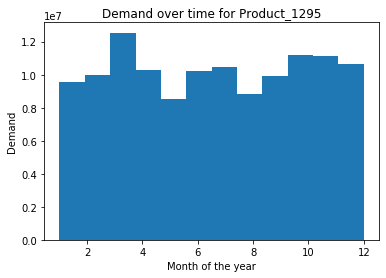

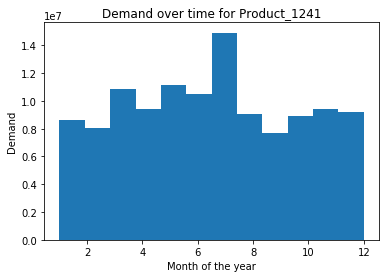

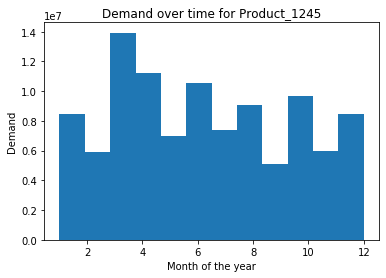

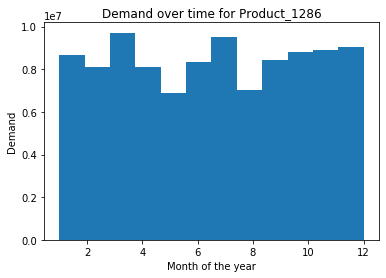

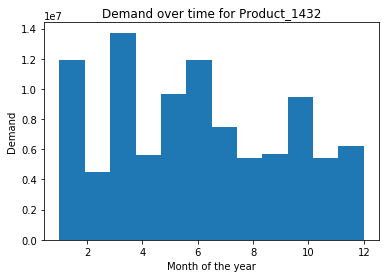

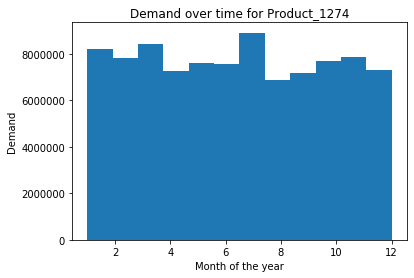

In [10]:
def plot_product_months(prod_name):
    prod = agg_data.query(f'Product_Code == "{prod_name}"')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.hist(prod['Month_of_Year'], bins=12, weights=prod['Order_Demand'])
    ax.set_title(f'Demand over time for {prod_name}')
    ax.set_xlabel('Month of the year')
    ax.set_ylabel('Demand')
    plt.show()

for p in largest:
    plot_product_months(f'Product_{p}')

For many of these products, seasonality is difficult to determine from these histograms.  Let's stick with product 1295.

# Forecasting

Now that we've chosen a product, let's see what insights we can gather from our data.  We'll use Facebook's Prophet library here, since it nicely bundles together time forecasting and visualizations.

In [11]:
prop_train = prod_data.query('Product_Code == "Product_1295"')[['Date', 'Order_Demand']]
prop_train = prop_train.rename(columns={'Date': 'ds', 'Order_Demand': 'y'})

m = Prophet()
m.fit(prop_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


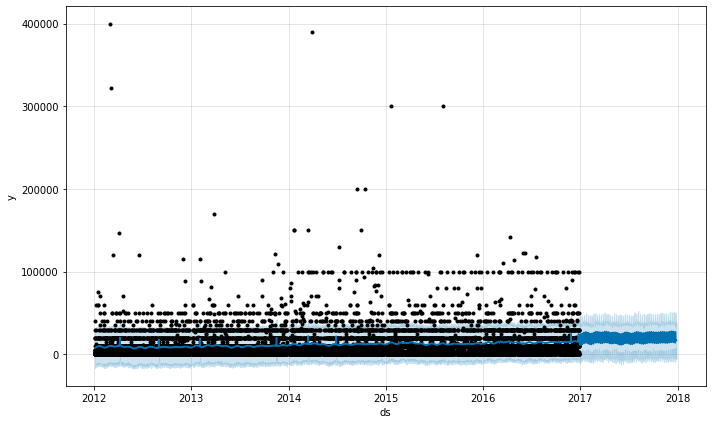

In [12]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

fig = m.plot(forecast)

These results seem a bit suboptimal, and it's easy to tell why by looking at the graph -- daily orders are too noisy, since many days have few or no orders.  Fortunately, we've already produced the monthly monthly order demands.  With any luck these will be a smoother, easier to work with time series.  Predicting month-to-month demand is probably more valuable to the warehouse than day-to-day anyways.

In [13]:
prop_train = agg_data.query('Product_Code == "Product_1295"')[['Month', 'Order_Demand']]
prop_train = prop_train.rename(columns={'Month': 'ds', 'Order_Demand': 'y'})

m = Prophet()
m.fit(prop_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


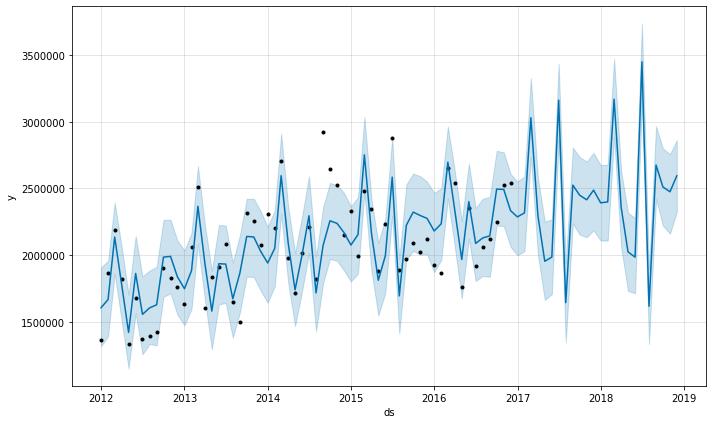

In [14]:
future = m.make_future_dataframe(periods=24, freq='M')
forecast = m.predict(future)

fig = m.plot(forecast)


Despite the noise of this dataset, Prophet seems to perform pretty well!  This graph depicts a general increase over the next two years, with high variance mirroring that of past years.

# Conclusion

I was pretty satisfied with the results of this time series forecasting -- we were able to produce reasonable predictions of future demand even though the raw data was relatively chaotic.

In the future, combining this data with additional factors would be interesting.  For example, economic projections and weather forecasts (depending on the product) might provide more accurate predictions.  Analysis of other annual factors like holidays would also be interesting.